In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score

import torch

from clusterless.utils import NP1DataLoader, ADVIDataLoader, fit_initial_gmm
# from clusterless.encoder import CAVI

In [2]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [3]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

#### load data

In [4]:
# np1_data_loader = NP1DataLoader(
#     probe_id = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0', 
#     geom_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016/np1_channel_map.npy', 
#     ephys_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016/subtraction_results_threshold_5', 
#     behavior_path = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/original_data'
# )

In [5]:
np1_data_loader = NP1DataLoader(
    probe_id = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943', 
    geom_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/np1_channel_map.npy', 
    ephys_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/subtraction_results_threshold_5', 
    # ephys_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/subtract_res_wf_pcs', 
    behavior_path = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/original_data'
)

Session ID: db4df448-e449-4a6f-a0e7-288711e7a75a
Probe ID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 (probe00)
First trial stimulus onset time: 40.81 sec
Last trial stimulus onset time: 2252.10 sec


In [6]:
region = 'po'

In [7]:
# trials = np1_data_loader.load_spike_features(region = 'vis')

In [12]:
trials = np1_data_loader.relocalize_kilosort(
    data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/kilosort_localizations',
    region = region)

Found 64 channels in region po


In [13]:
trials[-1].max(0)

array([2253.09932098,  253.        ,  102.8763763 , 2580.34814039,
         34.50404739])

In [14]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories_, rewards, priors = \
    np1_data_loader.load_behaviors('static')

Choices left: 0.361, right: 0.639
Stimuli left: 0.430, right: 0.570
Reward wrong: 0.087, correct: 0.913


In [15]:
advi_data_loader = ADVIDataLoader(
                         data = trials, 
                         behavior = choices.argmax(1), 
                         n_t_bins = 30)

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
kf_train_ids = []
kf_test_ids = []
for i, (train_ids, test_ids) in enumerate(kf.split(advi_data_loader.behavior)):
    kf_train_ids.append(train_ids)
    kf_test_ids.append(test_ids)

In [17]:
i = 0
train_trials, train_trial_ids, train_time_ids, test_trials, test_trial_ids, test_time_ids = \
    advi_data_loader.split_train_test(kf_train_ids[i], kf_test_ids[i])

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [18]:
train_trials.max(0)

array([ 253.        ,  159.        , 2640.        ,   52.97673035])

In [27]:
# gmm = fit_initial_gmm(np.concatenate(trials)[:,1:])
C = 50
gmm = GaussianMixture(n_components = C, 
                      covariance_type = 'full', 
                      init_params = 'k-means++')
gmm.fit(train_trials[:,1:])

GaussianMixture(init_params='k-means++', n_components=50)

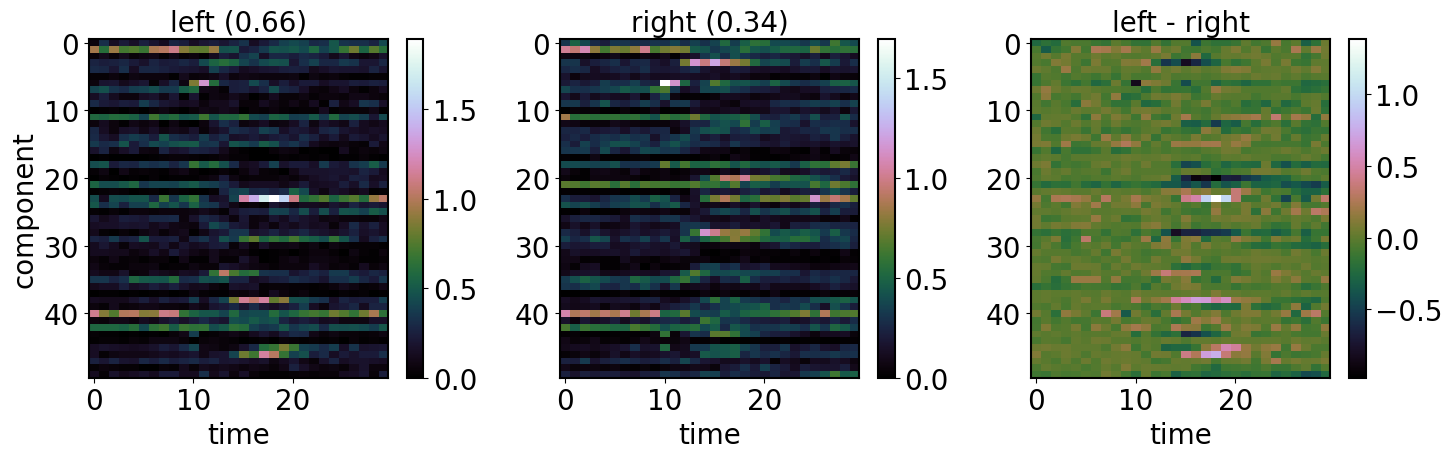

In [28]:
lambdas, p = advi_data_loader.compute_lambda(gmm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

f1 = ax1.imshow(lambdas[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title(f'left ({p:.2f})')
ax1.set_xlabel('time')
ax1.set_ylabel('component')
fig.colorbar(f1, ax = ax1)

f2 = ax2.imshow(lambdas[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title(f'right ({1-p:.2f})')
ax2.set_xlabel('time')
fig.colorbar(f2, ax = ax2)

f3 = ax3.imshow(lambdas[:,:,0] - lambdas[:,:,1], aspect='auto', cmap='cubehelix')
ax3.set_title('left - right')
ax3.set_xlabel('time')
fig.colorbar(f3, ax = ax3)

plt.tight_layout()

#### CAVI

In [21]:
def safe_log(x, minval=1e-10):
    return torch.log(x + minval)

def safe_divide(x, y):
    return torch.clip(x / y, min = 0, max = 1)

In [22]:
class CAVI():
    def __init__(self, init_mu, init_cov, init_lam, 
                 train_k_ids, train_t_ids, test_k_ids, test_t_ids):
        
        self.train_K = len(train_k_ids)
        self.test_K = len(test_k_ids)
        self.T = len(train_t_ids)
        self.C = init_mu.shape[0]
        self.D = init_mu.shape[1]
        self.init_mu = init_mu
        self.init_cov = init_cov
        self.init_lam = init_lam
        self.train_k_ids = train_k_ids
        self.train_t_ids = train_t_ids
        self.test_k_ids = test_k_ids
        self.test_t_ids = test_t_ids
        
    
    def _compute_normal_log_dens(self, s, mu, cov):
        
        log_dens = []
        for j in range(self.C):
            log_dens.append(
                torch.tensor(
                    multivariate_normal.logpdf(s, mu[j], cov[j])
                )
            )
        return torch.vstack(log_dens).T # (*, C)
    
    
    def _compute_enc_elbo(self, r, y, log_dens, norm_lam):
        
        elbo_1 = torch.sum(torch.tensor(
            [torch.einsum('i,i->', r[:,j], log_dens[:,j]) for j in range(self.C)]
        ))

        elbo_2 = torch.tensor(
            [ torch.einsum('ij,il,j->', r[self.train_t_ids[t]], 
                           y[self.train_t_ids[t]], norm_lam[:,t,1]) +
              torch.einsum('ij,il,j->', r[self.train_t_ids[t]], 
                           1-y[self.train_t_ids[t]], norm_lam[:,t,0]) for t in range(self.T) ]
            ).sum()

        elbo_3 = - torch.einsum('ij,ij->', safe_log(r), r)

        elbo = elbo_1 + elbo_2 + elbo_3 

        return elbo
    
    
    def _compute_dec_elbo(self, r, log_dens, norm_lam, nu, nu_k, p):
        
        elbo_1 = torch.sum(torch.tensor(
            [torch.einsum('i,i->', r[:,j], log_dens[:,j]) for j in range(self.C)]
        ))

        elbo_2 = torch.tensor(
            [ torch.einsum('ij,il,j->', r[self.test_t_ids[t]], 
                           nu[self.test_t_ids[t]], norm_lam[:,t,1]) +
              torch.einsum('ij,il,j->', r[self.test_t_ids[t]], 
                           1-nu[self.test_t_ids[t]], norm_lam[:,t,0]) for t in range(self.T) ]
            ).sum()

        elbo_3 = torch.sum(nu_k * safe_log(p) + (1-nu_k) * safe_log(1-p))

        elbo_4 = - torch.einsum('ij,ij->', safe_log(r), r)

        elbo_5 = - torch.sum(safe_log(nu_k) * nu_k)

        elbo = elbo_1 + elbo_2 + elbo_3 + elbo_4 + elbo_5

        return elbo
    
    
    def _encode_e_step(self, r, y, log_dens, norm_lam):
        
        for t in range(self.T):
            r[self.train_t_ids[t]] = torch.exp( log_dens[self.train_t_ids[t]] + \
                      torch.einsum('il,j->ij', y[self.train_t_ids[t]], norm_lam[:,t,1]) + \
                      torch.einsum('il,j->ij', 1-y[self.train_t_ids[t]], norm_lam[:,t,0])
            )
            r[self.train_t_ids[t]] = torch.einsum('ij,i->ij', r[self.train_t_ids[t]], 1/r[self.train_t_ids[t]].sum(1))
        return r
        
    
    def _encode_m_step(self, s, r, y, mu, lam):
        
        for j in range(self.C):
            no_j_idx = torch.cat([torch.arange(j), torch.arange(j+1, self.C)])
            lam_sum_no_j = lam[no_j_idx,:,:].sum(0)
            for t in range(self.T):
                num1 = torch.einsum('i,il,->', r[self.train_t_ids[t],j], y[self.train_t_ids[t]], lam_sum_no_j[t,1])
                denom1 = np.einsum('ij,il->', r[self.train_t_ids[t]][:,no_j_idx], y[self.train_t_ids[t]])
                num0 = torch.einsum('i,il,->', r[self.train_t_ids[t],j], 1-y[self.train_t_ids[t]], lam_sum_no_j[t,0])
                denom0 = np.einsum('ij,il->', r[self.train_t_ids[t]][:,no_j_idx], 1-y[self.train_t_ids[t]])
                lam[j,t,1], lam[j,t,0] = num1 / denom1, num0 / denom0
        norm_lam = safe_log(lam) - safe_log(lam.sum(0))

        norm = r.sum(0)
        mu = torch.einsum('j,ij,ip->jp', 1/norm, r, s)
        cov = [torch.einsum(
            ',i,ip,id->pd', 1/norm[j], r[:,j], s-mu[j], s-mu[j] ) for j in range(self.C)]
        
        return mu, cov, lam, norm_lam
    
    
    def _decode_e_step(self, r, log_dens, norm_lam, nu, nu_k, p):
        
        for t in range(self.T):
            r[self.test_t_ids[t]] = torch.exp( log_dens[self.test_t_ids[t]] + \
                      torch.einsum('il,j->ij', nu[self.test_t_ids[t]], norm_lam[:,t,1]) + \
                      torch.einsum('il,j->ij', 1-nu[self.test_t_ids[t]], norm_lam[:,t,0])
            )
            r[self.test_t_ids[t]] = torch.einsum('ij,i->ij', r[self.test_t_ids[t]], 1/r[self.test_t_ids[t]].sum(1))
        
        for k in range(self.test_K):
            y_tilde0, y_tilde1 = safe_log(1-p), safe_log(p)
            for t in range(self.T):
                k_t_ids = np.intersect1d(self.test_k_ids[k], self.test_t_ids[t])
                y_tilde0 += torch.einsum('ij,j->', r[k_t_ids], norm_lam[:,t,0])
                y_tilde1 += torch.einsum('ij,j->', r[k_t_ids], norm_lam[:,t,1])
            # y_tilde explode to 0 after exp(); need offset to ensure y_tilde stay in range
            offset = 1. / (torch.min(torch.tensor([y_tilde0, y_tilde1])) / -745.) 
            y_tilde0, y_tilde1 = torch.exp(y_tilde0 * offset), torch.exp(y_tilde1 * offset)
            nu_k[k] = safe_divide(y_tilde1, y_tilde0 + y_tilde1)
            nu[self.test_k_ids[k]] = nu_k[k]
            
        return r, nu, nu_k
    
    
    def _decode_m_step(self, s, r, nu_k, mu):
        
        p = nu_k.sum() / self.test_K
    
        norm = r.sum(0)
        mu = torch.einsum('j,ij,ip->jp', 1/norm, r, s)
        cov = [torch.einsum(
            ',i,ip,id->pd', 1/norm[j], r[:,j], s-mu[j], s-mu[j]) for j in range(self.C)]
        
        return p, mu, cov
    
    
    def encode(self, s, y, max_iter=20, eps=1e-6):
        # initialize
        r = torch.ones((s.shape[0], self.C)) / self.C
        lam = self.init_lam.clone()
        mu, cov = self.init_mu.clone(), self.init_cov.clone()
        norm_lam = safe_log(lam) - safe_log(lam.sum(0))
        
        # compute initial elbo
        log_dens = self._compute_normal_log_dens(s, mu, cov)
        elbo = self._compute_enc_elbo(r, y, log_dens, norm_lam)
        convergence = 1.
        elbos = [elbo]
        print(f'initial elbo: {elbos[-1]:.2f}')
        
        it = 1
        while convergence > eps or convergence < 0: 
            # E step
            r = self._encode_e_step(r, y, log_dens, norm_lam)
            
            # M step
            mu, cov, lam, norm_lam = self._encode_m_step(s, r, y, mu, lam)
            
            # compute new elbo
            log_dens = self._compute_normal_log_dens(s, mu, cov)
            elbo = self._compute_enc_elbo(r, y, log_dens, norm_lam)
            elbos.append(elbo)
            convergence = elbos[-1] - elbos[-2]

            print(f'iter: {it} elbo: {elbos[-1]:.2f}.')
            it +=1 
            if it > max_iter: 
                print('reached max iter allowed.')
                break

        if abs(convergence) <= eps:
            print('converged.')
            
        return r, lam, mu, torch.stack(cov), elbos
    
    
    def decode(self, s, init_p, init_mu, init_cov, init_lam, 
                test_k_ids, test_ids, max_iter=20, eps=1e-6):
        # initialize
        p = init_p.clone()
        r = torch.ones((s.shape[0], self.C)) / self.C
        mu, cov = init_mu.clone(), init_cov.clone()
        lam = init_lam.clone()
        norm_lam = safe_log(lam) - safe_log(lam.sum(0))
        nu_k = torch.rand(self.test_K)
        nu = torch.zeros(s.shape[0])
        for k in range(self.test_K):
            nu[test_k_ids == test_ids[k]] = nu_k[k]
        nu = nu.reshape(-1,1)
        
        # compute initial elbo
        log_dens = self._compute_normal_log_dens(s, mu, cov)
        elbo = self._compute_dec_elbo(r, log_dens, norm_lam, nu, nu_k, p)
        convergence = 1.
        elbos = [elbo]
        print(f'initial elbo: {elbos[-1]:.2f}')
        
        it = 1
        while convergence > eps or convergence < 0:
            # E step
            r, nu, nu_k = self._decode_e_step(r, log_dens, norm_lam, nu, nu_k, p)
            
            # M step
            p, mu, cov = self._decode_m_step(s, r, nu_k, mu)
            
            # compute new elbo
            log_dens = self._compute_normal_log_dens(s, mu, cov)
            elbo = self._compute_dec_elbo(r, log_dens, norm_lam, nu, nu_k, p)
            elbos.append(elbo)
            convergence = elbos[-1] - elbos[-2]

            print(f'iter: {it} elbo: {elbos[-1]:.2f}.')
            it +=1 
            if it > max_iter: 
                print('reached max iter allowed.')
                break

        if abs(convergence) <= eps:
            print('converged.')
    
        return r, nu_k, mu, torch.stack(cov), p, elbos
    
    
    def eval_performance(self, nu_k, y_test):
        acc = accuracy_score(y_test, 1. * ( nu_k > .5 ))
        auc = roc_auc_score(y_test, nu_k)
        print(f'decoding accuracy is {acc:.2f}')
        print(f'decoding auc is {auc:.2f}')
        return acc, auc
    
    
    
    def encode_gmm(self, trials, lams, means, covs, train, test, y_train, y_hat):
        
        enc_pis = lams / lams.sum(0)
        
        enc_all = np.zeros((len(train) + len(test), self.C, self.T))
        for i, k in enumerate(train):
            for t in range(self.T):
                enc_gmm = GaussianMixture(n_components=self.C, covariance_type='full')
                enc_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covs))
                enc_gmm.weights_ = enc_pis[:,t,y_train[i]]
                enc_gmm.means_ = means
                enc_gmm.covariances_ = covs
                if len(trials[k][t]) > 0:
                    enc_all[k,:,t] = enc_gmm.predict_proba(trials[k][t][:,1:]).sum(0)
                    
        for i, k in enumerate(test):
            for t in range(self.T):
                enc_gmm = GaussianMixture(n_components=self.C, covariance_type='full')
                enc_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covs))
                enc_gmm.weights_ = enc_pis[:,t,y_hat[i]]
                enc_gmm.means_ = means
                enc_gmm.covariances_ = covs
                if len(trials[k][t]) > 0:
                    enc_all[k,:,t] = enc_gmm.predict_proba(trials[k][t][:,1:]).sum(0)
        
        return enc_pis, enc_all

#### Train

In [29]:
C = len(gmm.means_)
T = lambdas.shape[1]

y_train = torch.zeros(train_trials.shape[0])
for k_idx, k in enumerate(advi_data_loader.train_ids):
    y_train[train_trial_ids == k] = advi_data_loader.train_behavior[k_idx]
y_train = y_train.reshape(-1,1)

In [30]:
cavi = CAVI(
    init_mu = torch.tensor(gmm.means_), 
    init_cov = torch.tensor(gmm.covariances_), 
    init_lam = torch.tensor(lambdas), 
    train_k_ids = [torch.argwhere(torch.tensor(train_trial_ids) == k).reshape(-1) for k in advi_data_loader.train_ids], 
    train_t_ids = [torch.argwhere(torch.tensor(train_time_ids) == t).reshape(-1) for t in range(T)],
    test_k_ids = [torch.argwhere(torch.tensor(test_trial_ids) == k).reshape(-1) for k in advi_data_loader.test_ids],
    test_t_ids = [torch.argwhere(torch.tensor(test_time_ids) == t).reshape(-1) for t in range(T)]
)

In [31]:
%%time
enc_r, enc_lam, enc_mu, enc_cov, enc_elbo = cavi.encode(
    s = torch.tensor(train_trials[:,1:]),
    y = y_train, max_iter=30)

initial elbo: -2136542824.45
iter: 1 elbo: -782084.83.
iter: 2 elbo: -781922.34.
iter: 3 elbo: -781813.83.
iter: 4 elbo: -781663.35.
iter: 5 elbo: -781515.29.
iter: 6 elbo: -781397.40.
iter: 7 elbo: -781304.51.
iter: 8 elbo: -781207.24.
iter: 9 elbo: -781088.10.
iter: 10 elbo: -780934.43.
iter: 11 elbo: -780756.64.
iter: 12 elbo: -780633.36.
iter: 13 elbo: -780542.21.
iter: 14 elbo: -780453.63.
iter: 15 elbo: -780381.06.
iter: 16 elbo: -780312.42.
iter: 17 elbo: -780243.03.
iter: 18 elbo: -780180.39.
iter: 19 elbo: -780125.93.
iter: 20 elbo: -780078.15.
iter: 21 elbo: -780029.29.
iter: 22 elbo: -779964.36.
iter: 23 elbo: -779890.34.
iter: 24 elbo: -779830.79.
iter: 25 elbo: -779790.89.
iter: 26 elbo: -779764.51.
iter: 27 elbo: -779744.53.
iter: 28 elbo: -779729.06.
iter: 29 elbo: -779716.81.
iter: 30 elbo: -779706.50.
reached max iter allowed.
CPU times: user 8min 44s, sys: 14.1 s, total: 8min 58s
Wall time: 1min 7s


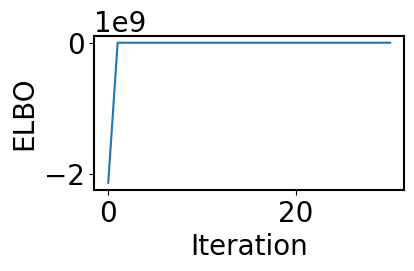

In [32]:
plt.figure(figsize=(4,2))
plt.plot(enc_elbo)
plt.xlabel("Iteration")
plt.ylabel("ELBO");

In [33]:
dec_r, dec_nu, dec_mu, dec_cov, dec_p, dec_elbo = cavi.decode(
    s = torch.tensor(test_trials[:,1:]),
    init_p = torch.tensor([p]), 
    init_mu = enc_mu, 
    init_cov = enc_cov, 
    init_lam = enc_lam, 
    test_k_ids = test_trial_ids, 
    test_ids = advi_data_loader.test_ids, 
    max_iter=10
)

initial elbo: -547020527.95
iter: 1 elbo: -189067.71.
iter: 2 elbo: -188467.25.
iter: 3 elbo: -188389.79.
iter: 4 elbo: -188367.41.
iter: 5 elbo: -188354.03.
iter: 6 elbo: -188345.47.
iter: 7 elbo: -188339.72.
iter: 8 elbo: -188334.94.
iter: 9 elbo: -188330.51.
iter: 10 elbo: -188326.39.
reached max iter allowed.


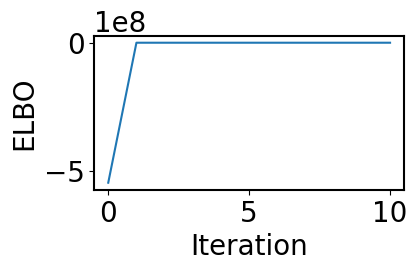

In [34]:
plt.figure(figsize=(4,2))
plt.plot(dec_elbo)
plt.xlabel("Iteration")
plt.ylabel("ELBO");

In [35]:
from sklearn.linear_model import LogisticRegression

def static_decoder(x, y, train, test):
    '''
    
    '''
    x_train = x.reshape(-1, x.shape[1] * x.shape[2])[train]
    x_test = x.reshape(-1, x.shape[1] * x.shape[2])[test]
    y_train = y[train]
    y_test = y[test]

    ridge = LogisticRegression(solver='liblinear')
    ridge.fit(x_train, y_train)
    y_prob = ridge.predict_proba(x_test)
    y_pred = y_prob.argmax(1)
    
    print(f'accuracy: {accuracy_score(y_test, y_pred):.3f}')
    
    return y_train, y_test, y_pred, y_prob

#### GMM

In [36]:
train = advi_data_loader.train_ids
test = advi_data_loader.test_ids

In [37]:
spike_train = np.concatenate(trials)
spike_times = spike_train[:,0]
spike_labels = gmm.predict(spike_train[:,2:])
spike_probs = gmm.predict_proba(spike_train[:,2:])

vanilla_gmm = np1_data_loader.prepare_decoder_input(
    np.c_[spike_times, spike_labels, spike_probs],
    is_gmm = True, n_t_bins = 30, regional = True)
print(vanilla_gmm.shape)

(230, 50, 30)


In [38]:
y_train, y_test, y_pred, _ = static_decoder(vanilla_gmm, advi_data_loader.behavior, train, test)

accuracy: 0.891


#### multi-unit thresholding

In [39]:
spike_channels = spike_train[:,1]

thresholded = np1_data_loader.prepare_decoder_input(
    np.c_[spike_times, spike_channels],
    is_gmm = False, n_t_bins = 30, regional = True)
print(thresholded.shape)

(230, 39, 30)


In [41]:
y_train, y_test, y_pred, _ = static_decoder(thresholded, advi_data_loader.behavior, train, test)

accuracy: 0.913


#### encoding MoG

In [43]:
cavi.eval_performance(dec_nu, advi_data_loader.test_behavior);

decoding accuracy is 0.85
decoding auc is 0.93


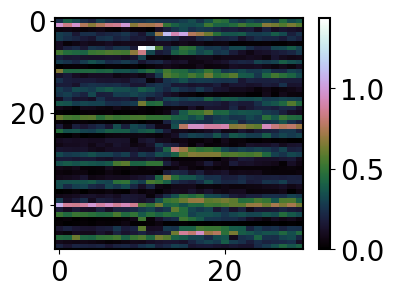

In [44]:
enc_pis, enc_all = cavi.encode_gmm(
    advi_data_loader.trials, 
    enc_lam.numpy(), 
    dec_mu.numpy(), 
    dec_cov.numpy(), 
    train, 
    test, 
    y_train, 
    y_pred)

plt.figure(figsize=(4,3))
plt.imshow(enc_all.mean(0), aspect='auto', cmap='cubehelix')
plt.colorbar();

In [45]:
_, _, _, _ = static_decoder(enc_all, advi_data_loader.behavior, train, test)

accuracy: 0.935


#### KS all units

In [46]:
ks_all = np1_data_loader.load_all_units(region=region)
ks_all = np.concatenate(ks_all)

all_units = np1_data_loader.prepare_decoder_input(
    ks_all, is_gmm = False, n_t_bins = 30, regional = True)
print(all_units.shape)

Found 88 KS units in region po
(230, 86, 30)


In [47]:
_, _, _, _ = static_decoder(all_units, advi_data_loader.behavior, train, test)

accuracy: 0.935


#### KS good units

In [48]:
ks_good = np1_data_loader.load_good_units(region=region)
ks_good = np.concatenate(ks_good)

good_units = np1_data_loader.prepare_decoder_input(
    ks_good, is_gmm = False, n_t_bins = 30, regional = True)
print(good_units.shape)

Found 18 good units in region po
(230, 18, 30)


In [49]:
_, _, _, _ = static_decoder(good_units, advi_data_loader.behavior, train, test)

accuracy: 0.674
